In [1]:
from collections import defaultdict

## see examples in https://www.gurobi.com/resource/modeling-examples-using-the-gurobi-python-api-in-jupyter-notebook/
import gurobipy as gp
from gurobipy import GRB

import math
import numpy as np
from datetime import datetime
import sys

from fruit_distribution import *   # import module to create the various desired fruit distributions 
from IG_data_analysis import *     # import module to analyze the data from the snapshots
from MIP_melon import *

# tested with Python 3.7.0 & Gurobi 9.0

## based on the Gurobi technician routing scheduling example
# https://gurobi.github.io/modeling-examples/technician_routing_scheduling/technician_routing_scheduling.html

In [2]:
def printScen(scenStr):
    sLen = len(scenStr)
    print("\n" + "*"*sLen + "\n" + scenStr + "\n" + "*"*sLen + "\n")

In [3]:
##################### VARIABLES FOR MIP PYTHON SCRIPT #####################

# Base model
n_arm = 4
n_row = 3

v_max      = 0.5
a_max      = 1.
# t_grab     = 0.1 

cell_l     = 0.3        # in m, length of the cell along the orchard row (y-axis), parallel to vehicle travel
cell_h     = 2. / n_row # in m, width/height of the horizontal row of arms (z-axis) perpendicular to vehicle travel
arm_reach  = 1  

v_vy_fruit_cmps = 8  # in cm/s

vehicle_l  = n_arm * cell_l
vehicle_h  = n_row * cell_h

horizon_l = 0

x_lim     = [0.2, 1.2]
y_lim     = [0. , vehicle_l]
z_lim     = [0., vehicle_h] 

print_out = 1
plot_out  = 1

n_snapshots = 1 # for now a constant

## set fruit distribution flag
# 0     == Raj's digitized fruits
# 1     == uniform random  (if algorithm == 1, use melon version)
# 2     == uniform random, equal cell density
# 3     == multiple densities separated by some space (only melon for now)
# 4     == fruit in vertical columns
# 5     == "melon" version of columns (user inputs desired no. fruits, z height, and distance between fruit in y-coord)
# 6     == Raj's digitized fruits, but which can reduce the density to a desired density
set_distribution = 6

## set algorithm being used 
# 1     == melon
# not 1 == not melon
set_algorithm    = 1

## set MIP model settings
# 0     == basic MIP model from the melon paper with arms not sharing space
# 1     == basic MIP model with velocity as a variable
# 2     == makespan MIP (have seperate code, don't use this until proven the same as the other)
set_MIPsettings = 0

## set how z-coord edges are calculated
# 0     == edges are divided equally along orchard height
# 1     == edges are divided so each row has equal number of fruit (or close to equal)
set_edges = 1

In [4]:
# ##################### RUN MIP PYTHON SCRIPT #####################
# # init the MIP melon object 
# mip_melon = MIP_melon(n_arm, n_row, 0, set_distribution, set_algorithm, set_MIPsettings, set_edges, v_vy_fruit_cmps, cell_l, cell_h, vehicle_h, horizon_l, x_lim, y_lim, z_lim)

# # create the simulated environment just once
# mip_melon.buildOrchard(1, set_algorithm, set_distribution)
# # create the up/down edges just once
# mip_melon.set_zEdges(set_edges, z_lim, n_row)

# # create the arm and fruit object lists
# mip_arm = mip_melon.createArms()
# mip_fruit = mip_melon.createFruits()

# printScen("Solving base scenario model")

# total_arms = n_arm * n_row

# FPT = 0
# solution_found = 0 # changes to 1 if at least one solution fits desired min values

# start_timer = datetime.now() # to figure out how looping through v_vy compares to pure MIP

# if set_MIPsettings == 0:
#     solution_found = 1 # set as done since there's only one run

#     fruit_picked_by = mip_melon.solve_melon_mip(mip_arm, mip_fruit, v_vy_fruit_cmps, set_MIPsettings)

#     v_vy = v_vy_fruit_cmps / 100 # change to m/s

#     chosen_j = np.copy(mip_melon.curr_j)

#     total_picked = np.sum(mip_melon.curr_j)
#     FPE = (total_picked / mip_melon.numFruit)
#     FPT = total_picked / (mip_melon.travel_l / v_vy)

#     print()
#     print('FPE:', FPE*100, '%, and FPT:', FPT, 'fruit/s') 
#     print('when v_vy set at', v_vy, 'm/s')
#     print()            
#     print('A total of', total_picked, 'fruits were harvested out of', mip_melon.numFruit)
#     print('How many fruit were picked by each arm: *front* ', mip_melon.curr_j, ' *back*, fruit')
#     print()

#     print('########################## END LOOP ###########################')
#     print()
#     print('Running once took:', datetime.now()-start_timer, 'h:m:s')
#     print()
#     print('###############################################################')
#     print()


# elif set_MIPsettings == 1:
#     # loop throught the list of velocity values 
#     for v_vy_curr in v_vy_cmps_try:
#         fruit_picked_by_curr = mip_melon.solve_melon_mip(mip_arm, mip_fruit, v_vy_curr, set_MIPsettings)

#         v_vy_mps = v_vy_curr / 100 # change to m/s

#         curr_total_picked = np.sum(mip_melon.curr_j)
#         curr_FPE = (curr_total_picked / mip_melon.numFruit)
#         curr_FPT = curr_total_picked / (mip_melon.travel_l / v_vy_mps)

#         print()
#         print('FPE:', curr_FPE*100, '%, and FPT:', curr_FPT, 'fruit/s') 
#         print('when v_vy set at', v_vy_mps, 'm/s')
#         print()            
#         print('A total of', curr_total_picked, 'fruits were harvested out of', mip_melon.numFruit)
#         print('How many fruit were picked by each arm: *front* ', mip_melon.curr_j, ' *back*, fruit')
#         print()

#         if curr_FPE < FPE_min - 0.03: 
#             # there is no way FPE rises, so either a solution was found, or it wasn't 
#             print('########################### FORCED END RUN ###########################')
#             print()
#             break

#         elif curr_FPE >= FPE_min:
#             if curr_FPT > FPT:

#                 solution_found = 1

#                 FPE          = curr_FPE
#                 FPT          = curr_FPT
#                 v_vy         = v_vy_mps
#                 total_picked = curr_total_picked
#                 chosen_j     = np.copy(mip_melon.curr_j)   # save the curr_j variable for the chosen run
#                 fruit_picked_by = fruit_picked_by_curr.copy() # copy the chosen run's fruit picked by list

#         curr_j = np.zeros([n_row, n_arm]) # reset so that the next run does not keep adding into the variable

#         print('########################### END RUN ###########################')
#         print()

#     print('########################## END LOOP ###########################')
#     print()
#     print('Looping through v_vy values took:', datetime.now()-start_timer, 'h:m:s')
#     print()
#     print('###############################################################')
#     print()


# #     v_vy = v_vy_cmps / 100 # change to m/s
# #     solve_melon_mip_read()

# if solution_found == 0:
#     print('NO SOLUTION was found')
#     print()

# elif solution_found == 1:
#     print()
#     print('chosen velocity {:.3f} m/s'.format(v_vy)) 
#     print('Number of fruits picked by each arm: *bottom* \n *back* ', chosen_j, ' *front* \n *top*')
#     print('FPE, {:.3f}%'.format(FPE*100), ', and FPT {:.3f}'.format(FPT))   
#     print()
#     print('A total of', total_picked, 'fruits were harvested out of', mip_melon.numFruit)
#     print()

# #     print('Sorted fruit list')
# #     print(sortedFruit)

#     # list for when there are multiple snapshots over the length of travel
#     snapshot_list = list()
#     snapshot_cell = list()

#     # calculate how long each arm was working vs idle
#     state_time = mip_melon.calcStateTime(fruit_picked_by, mip_melon.travel_l, v_vy, total_arms, n_row, n_arm, mip_melon.Td)

#     # fill in snapshot object and list with current results
#     snapshot = Snapshot(n_arm, n_row, horizon_l, vehicle_l, mip_melon.cell_l, v_max, a_max, set_algorithm, mip_melon.Td, v_vy, FPE, FPT, mip_melon.y_lim, mip_melon.numFruit, chosen_j, mip_melon.sortedFruit, fruit_picked_by, state_time)
#     snapshot_list.append(snapshot)
#     ## continue filling if needed: PCT, state_time, fruit_picked_by, fruit_list (all lists?)

#     horizon_indexes = mip_melon.getHorizonIndex(mip_melon.sortedFruit, mip_melon.q_vy, vehicle_l, horizon_l)
#     print(horizon_indexes)

#     ## calculate multiple R and v_vy values based on multiple slices of the current view
#     # return a list of fruit densities in each cell
#     d = mip_melon.calcDensity(mip_melon.q_vy, v_vy, n_row, n_arm, cell_l, cell_h, arm_reach, mip_melon.sortedFruit)
#     # print()
#     ## I wonder if calculating the max number of fruit in a bunch would help...

#     ## using the fruit densities, determine the vehicle speed to set a specific R value?
#     # currently, the R value would be 
#     R = mip_melon.calcR(v_vy, len(horizon_indexes), horizon_l, vehicle_h, arm_reach)  # calculated based on columns and the horizon length

#     snapshot_cell.append([d, R])

#     # # combine the results based on the various snapshots taken
#     results = IG_data_analysis(snapshot_list, snapshot_cell, mip_melon.travel_l, mip_melon.y_lim, set_algorithm, print_out)
#     if print_out == 1:
#         results.printSettings()

# #     [realFPE, realFPT] = results.realFPEandFPT(sortedFruit, y_lim, v_vy)
#     results.avgFPTandFPE()
#     # results.avgPCT()
#     # print()
#     # results.plotValuesOverDistance()
#     if plot_out == 1:
#         results.plotTotalStatePercent()

#         snapshot_schedules_2_plot = range(n_snapshots)  
#         results.plot2DSchedule(snapshot_schedules_2_plot)

In [5]:
##################### RUN SEPERATE MIP PER ROW #####################
row_mip_list         = list()
mip_arm_list         = list()
mip_fruit_list       = list()
fruit_picked_by_list = list()
chosen_j_list        = list()
total_picked_list    = list()
FPE_list             = list()
FPT_list             = list()

for row in range(n_row):
    # init the MIP melon object, n_row set to one for each since we're running it per row
    this_mip = MIP_melon(n_arm, 1, row, set_distribution, set_algorithm, set_MIPsettings, set_edges, v_vy_fruit_cmps, cell_l, cell_h, vehicle_h, horizon_l, x_lim, y_lim, z_lim)
    
    if row == 0:
        # create the simulated environment just once
        this_mip.buildOrchard(1, set_algorithm, set_distribution)
        # create the up/down edges just once
        this_mip.set_zEdges(set_edges, z_lim, n_row)
        
        # only use the first created sortedFruit and numFruit
        sortedFruit_0 = this_mip.sortedFruit
        numFruit_0    = this_mip.numFruit
        # only use the first created bottom and top z-edges
        bot_0  = this_mip.z_row_bot_edges
        top_0  = this_mip.z_row_top_edges
    else: 
        # set the calculated simulated environment for all the other rows
        this_mip.sortedFruit = sortedFruit_0
        this_mip.numFruit    = numFruit_0
        # set the bottom and top z-edges for all the other rows
        this_mip.z_row_bot_edges = bot_0
        this_mip.z_row_top_edges = top_0
        

    # create the arm and fruit object lists
    this_mip_arm = this_mip.createArms()
#     print('row', row, 'arms in list:', this_mip_arm)
#     print()
    this_mip_fruit = this_mip.createFruits()
#     print('row', row, 'fruits in list:', this_mip_fruit)
#     print()

    # rows are numbered from bottom 0 to top n_row
    row_mip_list.append(this_mip)
    mip_arm_list.append(this_mip_arm)
    mip_fruit_list.append(this_mip_fruit)
    

printScen("Solving base scenario model")

total_arms = n_arm * n_row

FPT = 0
solution_found = 0 # changes to 1 if at least one solution fits desired min values

start_timer = datetime.now() # to figure out how looping through v_vy compares to pure MIP

if set_MIPsettings == 0:
    solution_found = 1 # set as done since there's only one run
    
    v_vy = v_vy_fruit_cmps / 100 # change to m/s
    
    for row in range(n_row):
        this_fruit_picked_by = row_mip_list[row].solve_melon_mip(mip_arm_list[row], mip_fruit_list[row], v_vy_fruit_cmps, set_MIPsettings)
        fruit_picked_by_list.append(this_fruit_picked_by)
        
        this_chosen_j = np.copy(row_mip_list[row].curr_j)
        chosen_j_list.append(this_chosen_j)
        
        this_total_picked = np.sum(row_mip_list[row].curr_j)
        this_FPE = (this_total_picked / row_mip_list[row].numFruit)
        print()
        print('this run\'s FPE', this_FPE)
        print()
        this_FPT = this_total_picked / (row_mip_list[row].travel_l / v_vy)
        
        total_picked_list.append(this_total_picked)
        FPE_list.append(this_FPE*100)
        FPT_list.append(this_FPT)
        
    print()
    print('FPE:', FPE_list, '%, and FPT:', FPT_list, 'fruit/s') 
    print('when v_vy set at', v_vy, 'm/s')
    print()            
    print('A total of', total_picked_list, 'fruits were harvested out of', row_mip_list[0].numFruit)
    print('How many fruit were picked by each arm: *front* ', chosen_j_list, ' *back*, fruit')
    print()

    print('########################## END LOOP ###########################')
    print()
    print('Running once took:', datetime.now()-start_timer, 'h:m:s')
    print()
    print('###############################################################')
    print()
        

#     fruit_picked_by = mip_melon.solve_melon_mip(mip_arm, mip_fruit, v_vy_fruit_cmps, set_MIPsettings)

#     chosen_j = np.copy(mip_melon.curr_j)

#     total_picked = np.sum(mip_melon.curr_j)
#     FPE = (total_picked / mip_melon.numFruit)
#     FPT = total_picked / (mip_melon.travel_l / v_vy)

#     print()
#     print('FPE:', FPE*100, '%, and FPT:', FPT, 'fruit/s') 
#     print('when v_vy set at', v_vy, 'm/s')
#     print()            
#     print('A total of', total_picked, 'fruits were harvested out of', mip_melon.numFruit)
#     print('How many fruit were picked by each arm: *front* ', mip_melon.curr_j, ' *back*, fruit')
#     print()

#     print('########################## END LOOP ###########################')
#     print()
#     print('Running once took:', datetime.now()-start_timer, 'h:m:s')
#     print()
#     print('###############################################################')
#     print()


# elif set_MIPsettings == 1:
#     # loop throught the list of velocity values 
#     for v_vy_curr in v_vy_cmps_try:
#         fruit_picked_by_curr = mip_melon.solve_melon_mip(mip_arm, mip_fruit, v_vy_curr, set_MIPsettings)

#         v_vy_mps = v_vy_curr / 100 # change to m/s

#         curr_total_picked = np.sum(mip_melon.curr_j)
#         curr_FPE = (curr_total_picked / mip_melon.numFruit)
#         curr_FPT = curr_total_picked / (mip_melon.travel_l / v_vy_mps)

#         print()
#         print('FPE:', curr_FPE*100, '%, and FPT:', curr_FPT, 'fruit/s') 
#         print('when v_vy set at', v_vy_mps, 'm/s')
#         print()            
#         print('A total of', curr_total_picked, 'fruits were harvested out of', mip_melon.numFruit)
#         print('How many fruit were picked by each arm: *front* ', mip_melon.curr_j, ' *back*, fruit')
#         print()

#         if curr_FPE < FPE_min - 0.03: 
#             # there is no way FPE rises, so either a solution was found, or it wasn't 
#             print('########################### FORCED END RUN ###########################')
#             print()
#             break

#         elif curr_FPE >= FPE_min:
#             if curr_FPT > FPT:

#                 solution_found = 1

#                 FPE          = curr_FPE
#                 FPT          = curr_FPT
#                 v_vy         = v_vy_mps
#                 total_picked = curr_total_picked
#                 chosen_j     = np.copy(mip_melon.curr_j)   # save the curr_j variable for the chosen run
#                 fruit_picked_by = fruit_picked_by_curr.copy() # copy the chosen run's fruit picked by list

#         curr_j = np.zeros([n_row, n_arm]) # reset so that the next run does not keep adding into the variable

#         print('########################### END RUN ###########################')
#         print()

#     print('########################## END LOOP ###########################')
#     print()
#     print('Looping through v_vy values took:', datetime.now()-start_timer, 'h:m:s')
#     print()
#     print('###############################################################')
#     print()


# #     v_vy = v_vy_cmps / 100 # change to m/s
# #     solve_melon_mip_read()

# if solution_found == 0:
#     print('NO SOLUTION was found')
#     print()

# elif solution_found == 1:
#     print()
#     print('chosen velocity {:.3f} m/s'.format(v_vy)) 
#     print('Number of fruits picked by each arm: *bottom* \n *back* ', chosen_j, ' *front* \n *top*')
#     print('FPE, {:.3f}%'.format(FPE*100), ', and FPT {:.3f}'.format(FPT))   
#     print()
#     print('A total of', total_picked, 'fruits were harvested out of', mip_melon.numFruit)
#     print()

# #     print('Sorted fruit list')
# #     print(sortedFruit)

#     # list for when there are multiple snapshots over the length of travel
#     snapshot_list = list()
#     snapshot_cell = list()

#     # calculate how long each arm was working vs idle
#     state_time = mip_melon.calcStateTime(fruit_picked_by, mip_melon.travel_l, v_vy, total_arms, n_row, n_arm, mip_melon.Td)

#     # fill in snapshot object and list with current results
#     snapshot = Snapshot(n_arm, n_row, horizon_l, vehicle_l, mip_melon.cell_l, v_max, a_max, set_algorithm, mip_melon.Td, v_vy, FPE, FPT, mip_melon.y_lim, mip_melon.numFruit, chosen_j, mip_melon.sortedFruit, fruit_picked_by, state_time)
#     snapshot_list.append(snapshot)
#     ## continue filling if needed: PCT, state_time, fruit_picked_by, fruit_list (all lists?)

#     horizon_indexes = mip_melon.getHorizonIndex(mip_melon.sortedFruit, mip_melon.q_vy, vehicle_l, horizon_l)
#     print(horizon_indexes)

#     ## calculate multiple R and v_vy values based on multiple slices of the current view
#     # return a list of fruit densities in each cell
#     d = mip_melon.calcDensity(mip_melon.q_vy, v_vy, n_row, n_arm, cell_l, cell_h, arm_reach, mip_melon.sortedFruit)
#     # print()
#     ## I wonder if calculating the max number of fruit in a bunch would help...

#     ## using the fruit densities, determine the vehicle speed to set a specific R value?
#     # currently, the R value would be 
#     R = mip_melon.calcR(v_vy, len(horizon_indexes), horizon_l, vehicle_h, arm_reach)  # calculated based on columns and the horizon length

#     snapshot_cell.append([d, R])

#     # # combine the results based on the various snapshots taken
#     results = IG_data_analysis(snapshot_list, snapshot_cell, mip_melon.travel_l, mip_melon.y_lim, set_algorithm, print_out)
#     if print_out == 1:
#         results.printSettings()

# #     [realFPE, realFPT] = results.realFPEandFPT(sortedFruit, y_lim, v_vy)
#     results.avgFPTandFPE()
#     # results.avgPCT()
#     # print()
#     # results.plotValuesOverDistance()
#     if plot_out == 1:
#         results.plotTotalStatePercent()

#         snapshot_schedules_2_plot = range(n_snapshots)  
#         results.plot2DSchedule(snapshot_schedules_2_plot)

Total fruit in the orchard row 310

length of sortedFruit 310

number of fruit in each row, rounded down 103
bottom z-axis edges [[0.         1.04407702 1.54065916]
 [0.         1.04407702 1.54065916]
 [0.         1.04407702 1.54065916]
 [0.         1.04407702 1.54065916]]

top z-axis edges [[1.04407702 1.54065916 2.        ]
 [1.04407702 1.54065916 2.        ]
 [1.04407702 1.54065916 2.        ]
 [1.04407702 1.54065916 2.        ]]


***************************
Solving base scenario model
***************************

number of fruits: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 11

 21315 12354  102.78306   50   10   99.00000  103.00000  4.04%   5.2   98s
 27934 15760  100.00000   55    2   99.00000  103.00000  4.04%   5.2  100s
 45801 25334     cutoff   55        99.00000  103.00000  4.04%   5.1  105s
 58573 32088  101.62679   35    7   99.00000  103.00000  4.04%   5.1  110s
 76644 41340     cutoff   50        99.00000  103.00000  4.04%   5.1  115s
 87527 46943  101.00000   57    4   99.00000  103.00000  4.04%   5.1  120s
 103086 55714  100.00000   68    2   99.00000  103.00000  4.04%   5.1  125s
 121441 65508  103.00000   46   10   99.00000  103.00000  4.04%   5.1  130s
 137535 74061  103.00000   43   10   99.00000  103.00000  4.04%   5.1  135s
 151182 80986  102.00000   47    8   99.00000  103.00000  4.04%   5.1  140s
 168406 90249  101.85576   50    5   99.00000  103.00000  4.04%   5.1  145s
 182674 97127  100.87324   53    3   99.00000  103.00000  4.04%   5.1  150s
 199487 106163  102.00000   45    6   99.00000  103.00000  4.04%   5.1  155s
 214218 114064  1

In [2]:
## Functions
def getRNGSeedList(n_runs):
        '''
           Open the random seed list rngseed_list_20200901.csv with 200 seeds for each of the 3 real fruit coordinate axis
           and 3 fake fruit coordinate axis.
        '''
        # keeps track of the row number of the csv being read (each row contains the seeds for one run)
        csv_i     = 0

        seed_list = list()

        with open('./rngseed_list_20200901.csv') as csvfile:
            reader = csv.reader(csvfile, delimiter=',', quoting=csv.QUOTE_NONNUMERIC)
            for row in reader:
                seed_list.append(row)
                if csv_i == n_runs:
                    break

                csv_i += 1

        # print(seed_list)
        return(seed_list)
    
    
def createFruit(fruitD, set_algorithm, set_distribution, density, x_seed, y_seed, z_seed):
        if set_distribution == 0:
            csv_file = './TREE_FRUIT_DATA/apple_tree_data_2015/Applestotheright.csv'
            [numFruit, sortedFruit] = fruitD.csvFile(csv_file, 0)

        elif set_distribution == 1:
            if set_algorithm == 1:
                [numFruit, sortedFruit] = fruitD.uniformRandomMelon(density, y_seed, z_seed)
            else:
                [numFruit, sortedFruit] = fruitD.uniformRandom(density, x_seed, y_seed, z_seed)
            # print()
            # print('--------------------------------------------')
            # print('Number of fruit:', numFruit)
            # print()

        elif set_distribution == 2: 
            fruit_in_cell = math.ceil(density * (cell_h*cell_l*arm_reach)) # num of fruit in front of cell if using (equalCellDensity())
            print('Number of fruit in each cell:', fruit_in_cell)
            print()
            [numFruit, sortedFruit] = fruitD.equalCellDensity(n_row, n_arm, cell_h, cell_l, arm_reach, fruit_in_cell, x_seed, y_seed, z_seed)

        elif set_distribution == 3: 
            densities = np.array([5, 4, 3])
            [numFruit, sortedFruit] = fruitD.uniformRandomMelon_MultipleDensity(densities, y_seed, z_seed)

        elif set_distribution == 4: 
            [numFruit, sortedFruit] = fruitD.column(v_vy, v_max, a_max, t_grab, n_row, n_arm, cell_h, z_seed)
            
        elif set_distribution == 5:
            z_coord = (cell_h / 2) + 0.7
            [numFruit, sortedFruit] = fruitD.columnUniform_melon(n_fruit, d_y, z_coord)
            
        elif set_distribution == 6:
            csv_file = './TREE_FRUIT_DATA/apple_tree_data_2015/Applestotheright.csv'
            [numFruit, sortedFruit] = fruitD.csvFile_reduced(csv_file, 0, density, x_seed)

        else: 
            print('not a correct fruit distribution, defaulting to uniform random')
            if set_algorithm == 1:
                [numFruit, sortedFruit] = fruitD.uniformRandomMelon(density, y_seed, z_seed)
            else:
                [numFruit, sortedFruit] = fruitD.uniformRandom(density, x_seed, y_seed, z_seed)

        return([numFruit, sortedFruit])
    
    
def calc_TW(arm_n, y_coord, v_vy):
    TW_start = (y_coord + (arm_n - 1)*cell_l) / v_vy
    TW_end   = (y_coord + arm_n*cell_l) / v_vy
    return([TW_start, TW_end])


def getHorizonIndex(sortedFruit, q_vy, vehicle_l, horizon_l):
    '''
    Saves this snapshot's horizon fruit indexes based on the sortedFruit indexes to 
    compare and remove picked fruit.
    '''
    # edges of the horizon based on vehicle location and length
    horizon_back  = q_vy + vehicle_l
    horizon_front = horizon_back + horizon_l

    H_fruit_index = np.where((sortedFruit[1,:] >= horizon_back) & (sortedFruit[1,:] < horizon_front))

    return(H_fruit_index[0])


def calcDensity(q_vy, v_vy, n_row, n_arm, cell_l, cell_h, arm_reach, sortedFruit):
    '''Get the fruit density, d, of each cell'''
    ## should the columns be based on cell length? number of arms? 
    #  should the columns be the same width? increase/decrease the closer to the front of vehicle?
    #  should I calculate R per horizontal row of arms?

    d = np.zeros([n_row, n_arm])  # total number of cells
    # starting position on the z-axis (up-down on robot)
    row_z = 0.

    for n in range(n_row):
        # starting position in the y_axis (front-back on robot)
        col_y = q_vy

        for k in range(n_arm):
            # print('col', n, 'row', k)
            # print('back', col_y, 'front', col_y + cell_l)
            # print('bottom', row_z, 'top', row_z + cell_h)
            index = np.where((sortedFruit[1,:] >= col_y) & (sortedFruit[1,:] < col_y + cell_l) & 
                        (sortedFruit[2,:] >= row_z) & (sortedFruit[2,:] < row_z + cell_h) & 
                        (sortedFruit[4,:] < 1))
            # save the number of fruit in this cell
            d[n,k] = len(index[0])
            # print(d)
            # move to the next column of cells
            col_y += cell_l

        # move up to the next cell on this column
        row_z += cell_h

    # before calculating the true density, check total number of fruit
    # print('which sums to', np.sum(d))   # has to be equal to numer of fruit
    # divide all the values by the volume of space in front of each cell 
    d = d / (arm_reach * cell_l * cell_h)

    # print('fruit density in each cell [fruit/m^3]:')
    # print(d)

    return(d)


def calcR(v_vy, fruit_in_horizon, horizon_l, vehicle_h, arm_reach):
    '''Calculate the R value given a speed and horizon volume and density'''
    try:
        density_H = fruit_in_horizon / (horizon_l * vehicle_h * arm_reach)
        time_H    = horizon_l / v_vy

        R         = density_H / time_H # in fruit / (m^3 * s)

    except ZeroDivisionError:
        R         = 0 

    # print('Fruit incoming rate based on the horizon [fruit/(m^3 s)]:')
    # print(R)
    return(R) 

def calcStateTime(fruit_picked_by, travel_l, v_vy, total_arms, n_row, n_arm, Td):
    # def calculateStateTimePercent(self, fruit_picked_by, total_distance):
        '''Calculates the time each arm is in each state so that it can plotState can plot the data'''
        # total_distance = self.y_lim[1] - self.y_lim[0]
        total_distance = travel_l
        total_time = total_distance / v_vy  # for snapshots? -> I'm deleting Tm and Tw data at each snapshot, problem
#         print('movement distance:', total_distance)
#         print('total move time:', total_time)

        ## states: idle, pick_yz, pick_x, grab, retract_x, move_z/unload
        # self.state_percent = np.zeros([self.total_arms, 6]) # save each arm's percent time in each of the six states 
        state_time = np.zeros([total_arms, 7]) # save each arm's percent time in each of the six states plus a total

        for n in range(n_row):
            for k in range(n_arm):
                tot_arm_index = k + (n*n_arm)
                # # calculate arm's move_yz using Tm
                # for tm in self.Tm_values[n][k]:
                #     self.state_time[tot_arm_index,1] += tm

                if n_row > 1:
                    num_picked = len(fruit_picked_by[n][k])
#                     print('arm', k, 'picked', num_picked, 'fruit, from', fruit_picked_by[n][k])
                else:
                    num_picked = len(fruit_picked_by[k])
#                     print('arm', k, 'picked', num_picked, 'fruit, from', fruit_picked_by[k])
                    
                busy = num_picked * Td
#                 print('so was busy', busy, 'total seconds')
#                 print()
                state_time[tot_arm_index,1] = busy  # setting Tm as the "handling time"

                # calculate idle by subtracting all before by total time: length_row / v
                state_time[tot_arm_index,0] = total_time - np.sum(state_time[tot_arm_index,:])
                # save the total time for this run to get total percent later
                state_time[tot_arm_index,6] = total_time
                
        return(state_time)
    
    
def set_zEdges(set_edges):
    '''
       Calculate the z-coord for each horizontal row, assuming the whole row shares these edges.
       Returns a n_row x n_arm matrix for both the bottom and top edges of each cell. 
    '''   
    # edges for the nth horizontal row of cells
    
    if set_edges == 0: 
        # divided equally by distance along orchard height
        # row bottom edge = n*self.cell_h
        bottom = np.linspace(0, (n_row*cell_h - cell_h), n_row, endpoint=True)

        bot_edge = np.tile(bottom, (n_arm, 1))
        top_edge = np.copy(bot_edge) + cell_h
    #     print('bottom edges:', bot_edge)
    #     print()
    #     print('top edges:', top_edge)
    #     print()
    elif set_edges == 1:
        # divided by number of fruit
        
        # make zero arrays for top and bottom. Since edges shared along horizontal row, can tile it by n_arm
        top    = np.zeros(n_row)
        bottom = np.zeros(n_row)
        
        fruit_in_row = math.floor(numFruit / n_row)  # total fruit in each horizontal row (round down, one row could be heavier)
        print('number of fruit in each row, rounded down', fruit_in_row)
        
        # get z-coord array
        z_coord = np.array(sortedFruit[2]) 
        # sort the array
        z_sorted = np.sort(z_coord)
#         print('sorted z-coord', z_sorted)
        
        for row in range(n_row-1):
            top[row]      = z_sorted[fruit_in_row*(row+1)]+0.0001
            bottom[row+1] = z_sorted[fruit_in_row*(row+1)]+0.0001 
            
        top[-1] = z_lim[1]
            
        bot_edge = np.tile(bottom, (n_arm, 1))
        top_edge = np.tile(top, (n_arm, 1))
        
    else:
        print('Not an edge setting, please try again')
    
    return([bot_edge, top_edge])

In [2]:
##################### VARIABLES FOR JUPYTER NOTEBOOK MIP #####################
## Constants 
## to print out from data analysis
print_out  = 1
plot_out   = 1

## settings
Td         = 2.      # fruit handling time
M          = 80     # arbitrarily large number, set 600 from paper
v_vy_fruit = 0.3     # in m/s, assumed vehicle velocity along orchard row to build line distribution
v_vy_fruit_cmps = 10
q_vy       = 0.      # in m, backmost, lowest coordinate of the vehicle

v_max      = 0.5
a_max      = 1.
t_grab     = 0.1 

n_row      = 1       # total number of horizontal rows with cells containg one arm per cell
n_arm      = 12       # number of arms in one horizontal row

density    = 16       # in fruit/m^2, makespan is being limited to rho = 2 with random placement
n_fruit    = 80      # in fruit, for melon column distribution

FPE_min    = 0.95

cell_l     = 0.3        # in m, length of the cell along the orchard row (y-axis), parallel to vehicle travel
cell_h     = 2. / n_row # in m, width/height of the horizontal row of arms (z-axis) perpendicular to vehicle travel

noRel_time_ub  = 80     # no relaxation heuristic max time to solve before moving to branch and bound (varies)
timLim_time_ub = 3600/3 # 3600*2
v_vy_ub_cmps   = 90     # in cm/s, when testing many velocities, this detemrines the top velocity tested
# v_vy_lb_cmps = math.ceil(cell_l / Td * 100) # chose to make into integer, ceil because smaller won't work
v_vy_lb_cmps   = 9

# use a loop of potential v_vy values to remove v_vy as a variable from the MIP formulation
v_vy_cmps_try = np.arange(v_vy_lb_cmps, v_vy_ub_cmps+1)
# print('velocities being attempted:', v_vy_cmps_try)

# cell_l     = l
# cell_h     = w
arm_reach  = 1.

vehicle_l  = n_arm * cell_l
vehicle_h  = n_row * cell_h

## for future addition of snapshots
horizon_l  = 0.

# array to save which arm picked which fruit
curr_j   = np.zeros([n_row, n_arm])

## set fruit distribution flag
# 0     == Raj's digitized fruits
# 1     == uniform random  (if algorithm == 1, use melon version)
# 2     == uniform random, equal cell density
# 3     == multiple densities separated by some space (only melon for now)
# 4     == fruit in vertical columns
# 5     == "melon" version of columns (user inputs desired no. fruits, z height, and distance between fruit in y-coord)
# 6     == Raj's digitized fruits, but which can reduce the density to a desired density
set_distribution = 6

## set algorithm being used 
# 1     == melon
# not 1 == not melon
set_algorithm    = 1

## set MIP model settings
# 0     == basic MIP model from the melon paper with arms not sharing space
# 1     == basic MIP model with velocity as a variable
# 2     == makespan MIP (have seperate code, don't use this until proven the same as the other)
set_MIPsettings = 0

## set how z-coord edges are calculated
# 0     == edges are divided equally along orchard height
# 1     == edges are divided so each row has equal number of fruit (or close to equal)
set_edges = 0

n_snapshots = 1 # for now a constant


In [3]:
## Get fruit list based on desired distribution
n_runs = 1

seed_list = getRNGSeedList(n_runs)

for run in range(n_runs):
    # get seeds for x, y, and z RNG (probably unneccessary right now, especially for x)
    seed = [seed_list[run][0], seed_list[run][1], seed_list[run][2]]
    x_seed = PCG64(int(seed[0]))
    y_seed = PCG64(int(seed[1]))
    z_seed = PCG64(int(seed[2]))
    
if set_distribution == 0:
    travel_l  = 12 + vehicle_l # in m
    density   = 48.167         # in fruit/m^2 (on avg.), constant
    n_runs    = 1

elif set_distribution == 1:
    travel_l  = 3 + vehicle_l # in m, usually 5 m + length

elif set_distribution == 3:
    travel_l  = 30 + vehicle_l # in m
    
elif set_distribution == 5:
    v_vy_fruit_mps = v_vy_fruit_cmps / 100
    d_y  = Td*v_vy_fruit_mps*(n_fruit+1)/(n_fruit+2) # kind of works 3/4 or 5/8 fruit with 1 arm: (Td/2)*v_vy
#     d_y  = Td*v_vy_fruit*(n_fruit+1)/(n_fruit+2) # kind of works 3/4 or 5/8 fruit with 1 arm: (Td/2)*v_vy
    print('with Td', Td, 'and v_vy for fruit distribution', v_vy_fruit_cmps, 'cm/s')
    print('d_y for this line of fruit:', d_y, 'so the total distance they take up:', d_y*n_fruit)
    travel_l  = d_y * n_fruit + vehicle_l # in m
    
elif set_distribution == 6:
    travel_l = 6 + vehicle_l # in m, should watch out because the total distance is actually 12

else: 
    travel_l  = 10 + vehicle_l # in m 
      
    
x_lim   = [0.2, 1.2]
y_lim   = [0. , travel_l - vehicle_l]
z_lim   = [0., vehicle_h] 

fruitD = fruitDistribution(x_lim, y_lim, z_lim)
[numFruit, sortedFruit] = createFruit(fruitD, set_algorithm, set_distribution, density, x_seed, y_seed, z_seed)

print('Total fruit in the orchard row',numFruit)
print()
print('length of sortedFruit', len(sortedFruit[0]))
# print('List of the x, y, and z coordinates of the sorted fruit')
# print(sortedFruit)

[z_row_bot_edges, z_row_top_edges] = set_zEdges(set_edges)   
print('bottom z-axis edges', z_row_bot_edges)
print()
print('top z-axis edges', z_row_top_edges)
print()

NameError: name 'getRNGSeedList' is not defined

In [5]:
class Arm():
    def __init__(self, row_n, arm_n):
        self.row_n = row_n
        self.arm_n = arm_n

    def __str__(self):
        return f"Arm: {self.arm_n}\n Horizontal Row Number: {self.row_n}"

In [6]:
class Fruit():
    def __init__(self, index, y_coord, z_coord):#, job, tStart, tEnd, tDue):
        self.index = index       # fruit's index when ordered by y-coordinate
        self.y_coord = y_coord   # y-coordinate of the fruit
        self.z_coord = z_coord
        
    def __str__(self):
        return f"Fruit Index: {self.index}\n  Y-axis location: {self.y_coord}\n"

In [7]:
class Job():
    def __init__(self, fruit_i, arm_k, v_vy, l):
        self.fruit_i  = fruit_i
        self.arm_k    = arm_k
        self.v_vy     = v_vy
        # k+1 was added because the MIP model in paper assumes k starts at 1
        self.TW_start = (self.fruit_i.y_coord + (self.arm_k.arm_n - 1 + 1)*cell_l) / (v_vy/100)
        self.TW_end   = (self.fruit_i.y_coord + (self.arm_k.arm_n + 1)*cell_l) / (v_vy/100)
        
class Job_v_vy():
    # for basic MIP with vehicle velocity as a variable
    def __init__(self, fruit_i, arm_k):
        self.fruit_i = fruit_i
        self.arm_k   = arm_k

In [8]:
## create arm object list
arm = list()

for r in range(n_row):
# for r in range(1, n_row+1):
    for k in range(n_arm):
#     for k in range(1, n_arm+1):
        this_arm = Arm(r, k)
        arm.append(this_arm)
    
# print(arm)

In [9]:
## create fruit object list
fruit = list()

for index in range(numFruit):
    y_coord = sortedFruit[1][index]
    z_coord = sortedFruit[2][index]
    this_fruit = Fruit(index, y_coord, z_coord)
#     print('Fruit index', index, 'should match this index', sortedFruit[3][index])
#     print('with y and z coordinates:', y_coord, z_coord)

    fruit.append(this_fruit)

# print(fruit)

In [10]:
# ## create job object list
# job = list()

# for k in arm:
#     for i in fruit:  
#         this_job = Job_v_vy(i, k)
# #         
# #         print('for arm', this_job.arm_k.arm_n, 'and fruit', this_job.fruit_i.index)
# #         print('TW starts at', this_job.TW_start, 'and TW ends at', this_job.TW_end)
#         job.append(this_job)
    
# print(len(job))
# print(len(arm)*len(fruit))

In [11]:
def solve_melon_mip(arm, fruit, v_vy_curr):
    ## Build useful data structures
    # lists:
    K = [*range(n_arm)]      # list of arm/cell numbers
    L = [*range(n_row)]             # list of horizontal row numbers, uses the argument-unpacking operator *
    N = [i.index for i in fruit]    # list of fruit indexes
    Y = [i.y_coord for i in fruit]  # list of fruits' y-coordinate (x-coordinate in the paper)
    Z = [i.z_coord for i in fruit]  # list of fruits' z-coordinate
    
#     print('number of cells/arms:',K, 'with length', len(K))
#     print()
#     print('number of horizontal rows:',L, 'with length', len(L))
#     print()
#     print('number of fruits:',N, 'with length', len(N))
#     print()
#     print('fruit y-coordinate:', Y, 'with length', len(Y))
#     print()
#     print('fruit z-coordinate:', Z, 'with length', len(Z))
#     print()
        
    total_fruit = len(N) # needed to constraint FPE to a high picking percentage

    ## create job object list
    job = list()

    for k in arm:
        for i in fruit:  
            this_job = Job(i, k, v_vy_curr, cell_l)
    #         
#             print('for arm', this_job.arm_k.arm_n, 'and fruit', this_job.fruit_i.index)
#             print('TW starts at', this_job.TW_start, 'and TW ends at', this_job.TW_end)
            job.append(this_job)
    
    if set_MIPsettings == 0 or set_MIPsettings == 1:
        TW_start = {i : [j.TW_start for j in job if j.fruit_i.index == i] for i in N}
        TW_end   = {i : [j.TW_end for j in job if j.fruit_i.index == i] for i in N}

    

    ### Create model
    m = gp.Model("v_vy_loop_mip")

    ### change needed model parameters
    ### see https://www.gurobi.com/documentation/9.5/refman/python_parameter_examples.html#PythonParameterExamples
    
    if set_MIPsettings == 2:
        # if velocity becomes a variable, it is multiplied with another variable requiring the following settings
        m.params.NonConvex = 2
        m.setParam('NonConvex', 2)

    # Due to *very* high complexity, limits time in the no relaxation heuristic
    # see https://www.gurobi.com/documentation/9.5/refman/norelheurtime.html
    m.setParam('NoRelHeurTime', noRel_time_ub)

    # limit the maximum amount of time the solver takes to find a solution -> if gap isn't 0% then "no solution"
    # if NoRel == TimeLimit, only NoRel used (https://support.gurobi.com/hc/en-us/community/posts/4414052781073-NoRel-and-setting-time-limits)
    m.setParam('TimeLimit', timLim_time_ub) # stop after half an hour


    ### Decision variables
    # Arm-fruit assignment (is fruit i picked by arm k)
    x = m.addVars(K, L, N, vtype=GRB.BINARY, name="x")

    # Time arm k, l reaches fruit i
    t_ub = (travel_l + cell_l) / (v_vy_curr/100)

    t = m.addVars(K, L, N, lb=0, ub=t_ub, name="t")
    
    if set_MIPsettings == 2:
        # Start and end of time window arm k can reach fruit i
        tw_s_ub = travel_l / (cell_l/Td) 
        tw_e_ub = (travel_l + cell_l) / (cell_l/Td) 

        tw_s = m.addVars(K, N, lb=0, ub=tw_s_ub, name="tw_s")
        tw_e = m.addVars(K, N, lb=0, ub=tw_e_ub, name="tw_e")

        # required because gurobi doesn't like >= or <= constraints that deal with two variables
        aux_max = m.addVars(K, N, lb=0, name="aux_max")
        aux_min = m.addVars(K, N, lb=0, name="aux_min")

        # in cm/s, vehicle velocity along orchard row
        # bounded by the cell length and Td (melon paper) and bounded by max velocity of the lift (90 cm/s)
        v_vy = m.addVar(vtype=GRB.INTEGER, lb=v_vy_lb_cmps, ub=v_vy_ub_cmps, name="v_vy")
        
        # add a starting guess value to the variable
        # see https://www.gurobi.com/documentation/9.5/refman/start.html#attr:Start
    #     v_vy.start = 61 # in cm/s

        # create a variable that saves the last picking time, or makespan
        makespan  = m.addVar(lb=0, name="makespan")
        t_max_arm = m.addVars(K, name='t_max')  # max t value for each arm
    

    ### Constraints
    # At most one arm can be assigned to a fruit (1)
    m.addConstrs((x.sum('*', '*', i) <= 1 for i in N), name="assignOne")

    # Time elapsed between pickup of any two fruit reached by the same arm is at least Td (2)
    m.addConstrs((t[k, l, i] + Td - t[k, l, j] <= M * (2 - x[k, l, j] - x[k, l, i]) for i in N for j in N for k in K for l in L if Y[j] > Y[i]), name="atLeast")
    
    # If fruit z-coord is outside of arm's range, do not pick it
    m.addConstrs(((x[k, l, i] == 0) for i in N for l in L for k in K if Z[i] < z_row_bot_edges[k,l] or Z[i] > z_row_top_edges[k,l]), name="verticalWorkArea")
    
    if set_MIPsettings == 0 or set_MIPsettings == 1:
        m.addConstrs((t[k, l, i] <= max(TW_start[i][k], TW_end[i][k]) for i in N for l in L for k in K), name="timeWinA")
        m.addConstrs((t[k, l, i] >= min(TW_start[i][k], TW_end[i][k]) for i in N for l in L for k in K), name="timeWinB")
        
        # If fruit z-coord is outside of arm's range, do not pick it
#         m.addConstrs(((x[k, l, i] == 0) for i in N for l in L for k in K if Z[i] < z_row_bot_edges[k,l] or Z[i] > z_row_top_edges[k,l]), name="verticalWorkArea")

    elif set_MIPsettings == 2:
        m.addConstrs(((tw_s[k, i] * (v_vy / 100) == (Y[i] + k * cell_l)) for i in N for k in K), name="TW_start")
        m.addConstrs(((tw_e[k, i] * (v_vy / 100) == (Y[i] + (k + 1) * cell_l)) for i in N for k in K), name="TW_end")

        # to learn how to deal with max/min with variables
        # see https://support.gurobi.com/hc/en-us/community/posts/360076808711-how-to-add-a-max-constr-General-expressions-can-only-be-equal-to-a-single-var
        m.addConstrs((aux_max[k, i] == gp.max_(tw_s[k, i], tw_e[k, i]) for i in N for k in K), name="auxMax")
        m.addConstrs((aux_min[k, i] == gp.min_(tw_s[k, i], tw_e[k, i]) for i in N for k in K), name="auxMin")

        # Ensure each node is visited within the given time window (3) and (4)
        # TW_start and TW_end are matching the fruit index number exactly (disctionary), so [2][0] == index 2 (even 
        # though it starts at zero, second arm back from 0th arm)  
        m.addConstrs(((t[k, l, i] <= aux_max[k, i]) for i in N for l in L for k in K), name="timeWinA")
        m.addConstrs(((t[k, l, i] >= aux_min[k, i]) for i in N for l in L for k in K), name="timeWinB")

        # Ensure at least 90% (or desired percentage) of available fruit are harvested
        m.addConstr((gp.quicksum(x[k, l, i] for i in N for l in L for k in K)/total_fruit >= FPE_min), name="percentHarvest")

        # set makespan as the latest t^k_i value
        # see https://support.gurobi.com/hc/en-us/community/posts/360071830171-Use-index-of-decision-variable-in-max-constraint
        m.addConstrs((t_max_arm[k] == gp.max_(t.select(k, '*', '*')) for k in K), name='max_value')

    #     makespan = m.addVar(name='makespan')
        m.addConstrs((makespan >= t_max_arm[k] for k in K), name='makespan_contraint')


    ### Objective function
    if set_MIPsettings == 0 or set_MIPsettings == 1:
        m.setObjective(gp.quicksum(x[k, l, i] for i in N for l in L for k in K), GRB.MAXIMIZE)
        
    elif set_MIPsettings == 2:
        m.setObjective((makespan), GRB.MINIMIZE)

    ## see https://github.com/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/04.03-Job-Shop-Scheduling.ipynb
    ## and https://support.gurobi.com/hc/en-us/community/posts/360071830171-Use-index-of-decision-variable-in-max-constraint

    ## write model into a file
    # see https://www.gurobi.com/documentation/9.5/refman/py_model_write.html
    # https://www.gurobi.com/documentation/9.5/refman/model_file_formats.html
    title_lp  = './mip_files/v_vy_' + str(v_vy_curr) + '_loop_mip.lp'
    title_mps = './mip_files/v_vy_' + str(v_vy_curr) + '_loop_mip.mps'
    m.write(title_lp)
    m.write(title_mps)
    m.optimize()
    
    status = m.Status
    if status in [GRB.INF_OR_UNBD, GRB.INFEASIBLE, GRB.UNBOUNDED]:
        print("Model is either infeasible or unbounded.")
#         sys.exit(0)
    elif status != GRB.OPTIMAL:
        print("Optimization terminated with status {}".format(status))
#         sys.exit(0)

    fruit_picked_by = list()    

    for n in range(n_row):
        if n_row > 1:
            fruit_picked_by.append([])

        for k in range(n_arm+1):
            if n_row > 1:
                fruit_picked_by[n].append([])
            else:
                fruit_picked_by.append([])

    ### Print results
    # Assignments    
#     print()
    for j in job:
        if x[j.arm_k.arm_n, j.arm_k.row_n, j.fruit_i.index].X > 0:
#             print('fruit', j.fruit_i.index, 'assigned to arm', j.arm_k.arm_n, 'at t = ', t[j.arm_k.arm_n, j.fruit_i.index].X)
#             if set_MIPsettings == 1:
#                 print('with tw start:', aux_min[j.arm_k.arm_n, j.fruit_i.index].X, 'and tw end:', aux_max[j.arm_k.arm_n, j.fruit_i.index].X)
            # save picked to sortedFruit
            sortedFruit[4, j.fruit_i.index] = 1
            curr_j[j.arm_k.row_n, j.arm_k.arm_n] += 1
            if n_row > 1:
                fruit_picked_by[j.arm_k.row_n][j.arm_k.arm_n].append(j.fruit_i.index)

            else:
                fruit_picked_by[j.arm_k.arm_n].append(j.fruit_i.index)

    no_pick = np.where(sortedFruit[4,:] == 0)
#     print('not picked indexes:', no_pick[0])

    for no_pick_i in no_pick[0]:
        # Adding the indexes of non-picked fruit to a sublist at the end of the first 
        # horizontal row's list of sublists
        if n_row > 1:
            # if multiple horizontal rows, append the non-picked sublist to the first horizontal row's list of lists
            fruit_picked_by[0][n_arm].append(no_pick_i)
        else:
            fruit_picked_by[n_arm].append(no_pick_i)

#     print('model variables:', m.getAttr("x", m.getVars()))
    print()
#     print('chosen velocity:', v_vy.X, 'cm/s')
    print('set M value:', M)
    print()


    # check that TW and t^k_i match indexes and arms
#     print()
#     for k in K:
#         for i in N:
#             print('TW start:', TW_start[i][k], 'TW end:', TW_end[i][k], 'and t^k_i', t[k, i].X)

    print('fruit picked by [0]', fruit_picked_by[0])
    print('fruit picked by [1]', fruit_picked_by[1])
    
    return(fruit_picked_by)


In [12]:
# def solve_melon_mip_read():
#     #### use solution file from solve_melon_mip to see what's going on
#     ### Create model
#     m = gp.read('v_vy_loop_mip.mps')
#     m.read('wall_start.mst')
    
#     m.optimize()

#     status = m.Status
#     if status in [GRB.INF_OR_UNBD, GRB.INFEASIBLE, GRB.UNBOUNDED]:
#         print("Model is either infeasible or unbounded.")
#         sys.exit(0)
#     elif status != GRB.OPTIMAL:
#         print("Optimization terminated with status {}".format(status))
#         sys.exit(0)
        
#     print()
    
#     ### Send results out for analysis
    
#     print('model variables:', m.getAttr("x", m.getVars()))
#     print()
    
#     fruit_picked_by = list()    
        
#     for n in range(n_row):
#         if n_row > 1:
#             fruit_picked_by.append([])
            
#         for k in range(n_arm+1):
#             if n_row > 1:
#                 fruit_picked_by[n].append([])
#             else:
#                 fruit_picked_by.append([])
            
#     ### Print results
#     # Assignments    
# #     print()
#     for j in job:
#         if x[j.arm_k.arm_n, j.fruit_i.index].X > 0:
#             print('fruit', j.fruit_i.index, 'assigned to arm', j.arm_k.arm_n, 'at t = ', t[j.arm_k.arm_n, j.fruit_i.index].X)
#             print('with tw start:', aux_min[j.arm_k.arm_n, j.fruit_i.index].X, 'and tw end:', aux_max[j.arm_k.arm_n, j.fruit_i.index].X)
#             # save picked to sortedFruit
#             sortedFruit[4, j.fruit_i.index] = 1
#             curr_j[j.arm_k.row_n, j.arm_k.arm_n] += 1
#             if n_row > 1:
#                 fruit_picked_by[j.arm_k.row_n][j.arm_k.arm_n].append(j.fruit_i.index)
                
#             else:
#                 fruit_picked_by[j.arm_k.arm_n].append(j.fruit_i.index)
                
#     no_pick = np.where(sortedFruit[4,:] == 0)
# #     print('not picked indexes:', no_pick[0])
    
#     for no_pick_i in no_pick[0]:
#         fruit_picked_by[n_arm].append(no_pick_i)
            
# #     print('model variables:', m.getAttr("x", m.getVars()))
#     print()
# #     print('chosen velocity:', v_vy.X, 'cm/s')
#     print('M value for current run:', M)
#     print()
    
    
#     # check that TW and t^k_i match indexes and arms
# #     print()
# #     for k in K:
# #         for i in N:
# #             print('TW start:', TW_start[i][k], 'TW end:', TW_end[i][k], 'and t^k_i', t[k, i].X)

# #     return([fruit_picked_by, v_vy.X])
#     return(fruit_picked_by)


In [13]:
def printScen(scenStr):
    sLen = len(scenStr)
    print("\n" + "*"*sLen + "\n" + scenStr + "\n" + "*"*sLen + "\n")

In [14]:
## create snapshot object for data analysis
class Snapshot(object):
    def __init__(self, n_arm, n_row, horizon_l, vehicle_l, cell_l, v_max, a_max, set_algorithm, Td, v_vy, FPE, FPT, y_lim, numFruit, curr_j, sortedFruit, fruit_picked_by, state_time):
        # constants for the whole run
        self.n_arm      = n_arm
        self.n_row      = n_row
        self.horizon_l  = horizon_l
        self.vehicle_l  = vehicle_l
        self.cell_l     = cell_l
        self.v_max      = v_max
        self.a_max      = a_max
        if set_algorithm == 1:
            self.Td     = Td
            
        # constants and results for each snapshot in the run
        self.v_vy       = v_vy
        self.FPE        = FPE
        self.FPT        = FPT
        self.y_lim      = y_lim
        self.actual_numFruit = numFruit
        self.curr_j          = curr_j
        self.avg_PCT         = 0.
        self.state_time      = state_time
        self.fruit_picked_by = fruit_picked_by
        self.sortedFruit     = sortedFruit

    def __str__(self):
        return f"Arm: {self.arm_n}\n Horizontal Row Number: {self.row_n}"
    

## 


***************************
Solving base scenario model
***************************

Set parameter Username
Academic license - for non-commercial use only - expires 2022-06-16
Set parameter NoRelHeurTime to value 80
Set parameter TimeLimit to value 1200
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 582490 rows, 7440 columns and 2310120 nonzeros
Model fingerprint: 0xae58dccf
Variable types: 3720 continuous, 3720 integer (3720 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        [7e-01, 2e+02]
Found heuristic solution: objective 251.0000000
Presolve removed 490944 rows and 24 columns
Presolve time: 2.30s
Presolved: 91546 rows, 7416 columns, 368364 nonzeros
Variable types: 3672 continuous, 3744 integer (3744 binary)
Found heuristic solution: objective 281.0000000
Starting NoRel heur

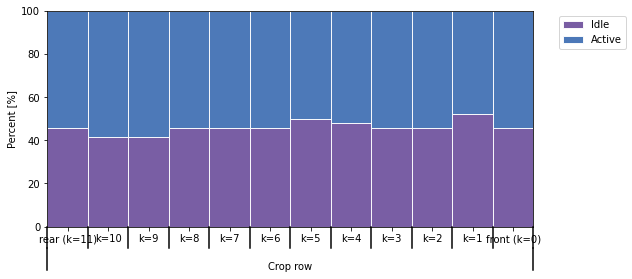

Saving 2D plot of the schedule ./plots/2dschedule.png


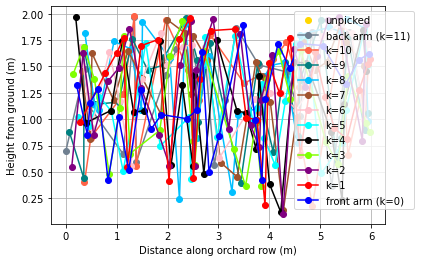

In [15]:
if __name__ == "__main__":
    # Base model
    printScen("Solving base scenario model")
    
    total_arms = n_arm * n_row
    
    FPT = 0
    solution_found = 0 # changes to 1 if at least one solution fits desired min values
    
    start_timer = datetime.now() # to figure out how looping through v_vy compares to pure MIP
    
    if set_MIPsettings == 0:
        solution_found = 1 # set as done since there's only one run
        
        fruit_picked_by = solve_melon_mip(arm, fruit, v_vy_fruit_cmps, set_MIPsettings)
        
        v_vy = v_vy_fruit_cmps / 100 # change to m/s
        
        chosen_j = np.copy(curr_j)

        total_picked = np.sum(curr_j)
        FPE = (total_picked / numFruit)
        FPT = total_picked / (travel_l / v_vy)

        print()
        print('FPE:', FPE*100, '%, and FPT:', FPT, 'fruit/s') 
        print('when v_vy set at', v_vy, 'm/s')
        print()            
        print('A total of', total_picked, 'fruits were harvested out of', numFruit)
        print('How many fruit were picked by each arm: *front* ', curr_j, ' *back*, fruit')
        print()
        
        print('########################## END LOOP ###########################')
        print()
        print('Running once took:', datetime.now()-start_timer, 'h:m:s')
        print()
        print('###############################################################')
        print()
        
        
    elif set_MIPsettings == 1:
        # loop throught the list of velocity values 
        for v_vy_curr in v_vy_cmps_try:
            fruit_picked_by_curr = solve_melon_mip(arm, fruit, v_vy_curr, set_MIPsettings)

            v_vy_mps = v_vy_curr / 100 # change to m/s

            curr_total_picked = np.sum(curr_j)
            curr_FPE = (curr_total_picked / numFruit)
            curr_FPT = curr_total_picked / (travel_l / v_vy_mps)

            print()
            print('FPE:', curr_FPE*100, '%, and FPT:', curr_FPT, 'fruit/s') 
            print('when v_vy set at', v_vy_mps, 'm/s')
            print()            
            print('A total of', curr_total_picked, 'fruits were harvested out of', numFruit)
            print('How many fruit were picked by each arm: *front* ', curr_j, ' *back*, fruit')
            print()
            
            if curr_FPE < FPE_min - 0.03: 
                # there is no way FPE rises, so either a solution was found, or it wasn't 
                print('########################### FORCED END RUN ###########################')
                print()
                break

            elif curr_FPE >= FPE_min:
                if curr_FPT > FPT:

                    solution_found = 1

                    FPE          = curr_FPE
                    FPT          = curr_FPT
                    v_vy         = v_vy_mps
                    total_picked = curr_total_picked
                    chosen_j     = np.copy(curr_j)   # save the curr_j variable for the chosen run
                    fruit_picked_by = fruit_picked_by_curr.copy() # copy the chosen run's fruit picked by list

            curr_j = np.zeros([n_row, n_arm]) # reset so that the next run does not keep adding into the variable

            print('########################### END RUN ###########################')
            print()
    
        print('########################## END LOOP ###########################')
        print()
        print('Looping through v_vy values took:', datetime.now()-start_timer, 'h:m:s')
        print()
        print('###############################################################')
        print()
    
    
#     v_vy = v_vy_cmps / 100 # change to m/s
#     solve_melon_mip_read()

    if solution_found == 0:
        print('NO SOLUTION was found')
        print()

    elif solution_found == 1:
        print()
        print('chosen velocity {:.3f} m/s'.format(v_vy)) 
        print('Number of fruits picked by each arm: *bottom* \n *back* ', chosen_j, ' *front* \n *top*')
        print('FPE, {:.3f}%'.format(FPE*100), ', and FPT {:.3f}'.format(FPT))   
        print()
        print('A total of', total_picked, 'fruits were harvested out of', numFruit)
        print()

    #     print('Sorted fruit list')
    #     print(sortedFruit)

        # list for when there are multiple snapshots over the length of travel
        snapshot_list = list()
        snapshot_cell = list()

        # calculate how long each arm was working vs idle
        state_time = calcStateTime(fruit_picked_by, travel_l, v_vy, total_arms, n_row, n_arm, Td)

        # fill in snapshot object and list with current results
        snapshot = Snapshot(n_arm, n_row, horizon_l, vehicle_l, cell_l, v_max, a_max, set_algorithm, Td, v_vy, FPE, FPT, y_lim, numFruit, chosen_j, sortedFruit, fruit_picked_by, state_time)
        snapshot_list.append(snapshot)
        ## continue filling if needed: PCT, state_time, fruit_picked_by, fruit_list (all lists?)

        horizon_indexes = getHorizonIndex(sortedFruit, q_vy, vehicle_l, horizon_l)
        print(horizon_indexes)

        ## calculate multiple R and v_vy values based on multiple slices of the current view
        # return a list of fruit densities in each cell
        d = calcDensity(q_vy, v_vy, n_row, n_arm, cell_l, cell_h, arm_reach, sortedFruit)
        # print()
        ## I wonder if calculating the max number of fruit in a bunch would help...

        ## using the fruit densities, determine the vehicle speed to set a specific R value?
        # currently, the R value would be 
        R = calcR(v_vy, len(horizon_indexes), horizon_l, vehicle_h, arm_reach)  # calculated based on columns and the horizon length

        snapshot_cell.append([d, R])

        # # combine the results based on the various snapshots taken
        results = IG_data_analysis(snapshot_list, snapshot_cell, travel_l, y_lim, set_algorithm, print_out)
        if print_out == 1:
            results.printSettings()

    #     [realFPE, realFPT] = results.realFPEandFPT(sortedFruit, y_lim, v_vy)
        results.avgFPTandFPE()
        # results.avgPCT()
        # print()
        # results.plotValuesOverDistance()
        if plot_out == 1:
            results.plotTotalStatePercent()

            snapshot_schedules_2_plot = range(n_snapshots)  
            results.plot2DSchedule(snapshot_schedules_2_plot)